# Artificial Intelligence
## Computer Vision / Convolutional Neural Networks (CNN)
### Harmful Species Identification (Spotted Lantern Fly vs. Asian Longhorn Beetle)

### What is a convolutional neural network (CNN)?

A convolutional neural network (CNN) is a category of machine learning model, namely a type of deep learning algorithm well suited to analyzing visual data. CNNs -- sometimes referred to as convnets -- use principles from linear algebra, particularly convolution operations, to extract features and identify patterns within images. Although CNNs are predominantly used to process images, they can also be adapted to work with audio and other signal data.

CNN architecture is inspired by the connectivity patterns of the human brain -- in particular, the visual cortex, which plays an essential role in perceiving and processing visual stimuli. The artificial neurons in a CNN are arranged to efficiently interpret visual information, enabling these models to process entire images. Because CNNs are so effective at identifying objects, they are frequently used for computer vision tasks such as image recognition and object detection, with common use cases including self-driving cars, facial recognition and medical image analysis.

Unlike CNNs, older forms of neural networks often needed to process visual data in a piecemeal manner, using segmented or lower-resolution input images. A CNN's comprehensive approach to image recognition lets it outperform a traditional neural network on a range of image-related tasks and, to a lesser extent, speech and audio processing.

### How do convolutional neural networks work?
CNNs use a series of layers, each of which detects different features of an input image. Depending on the complexity of its intended purpose, a CNN can contain dozens, hundreds or even thousands of layers, each building on the outputs of previous layers to recognize detailed patterns.


Reference:
+ https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats
+ https://pythonawesome.com/an-animated-and-smart-progress-bar-for-python/
+ https://www.tensorflow.org/tutorials/images/cnn
+ https://www.geeksforgeeks.org/computer-vision/
+ https://www.machinelearningnuggets.com/cnn-tensorflow/
+ https://www.datacamp.com/tutorial/cnn-tensorflow-python

## Environment Check

In [ ]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#- Google Colab Check
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import sys
RunningInCOLAB = False
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    print("You are running this notebook in Google Colab.")
else:
    print("You are running this notebook with Jupyter iPython runtime.")

if RunningInCOLAB:
  # Install a pip package in the current Jupyter kernel
  import sys
  !{sys.executable} -m pip install imageio --quiet
  !{sys.executable} -m pip install seaborn --quiet
  !{sys.executable} -m pip install alive-progress --quiet


## Libraries

In [3]:
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# a set of libraries that perhaps should always be in Python source
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import os
import socket
import sys
import getopt
import inspect
import warnings
import json
import pickle
from pathlib import Path
import itertools
import datetime
import re
import shutil
import string
import io

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Additional libraries for this work
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import math
from base64 import b64decode
from IPython.display import Image
from IPython.display import clear_output
import requests
from random import random
from random import randint
from random import seed

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Graphics
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
import PIL.ImageOps
from imageio import imread
import seaborn as sns

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Data Science Libraries
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import numpy as np
import pandas as pd

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Tensorflow and related AI libraries
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

#existing trained model
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# progress bar
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
from alive_progress import alive_bar
#from alive_progress.styles import showtime, Show
from tqdm.notebook import trange, tqdm

warnings.filterwarnings('ignore')               # don't print out warnings

## Variables

In [4]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1
DEBUG_DATA = 0

# CODE CONSTRAINTS
VERSION_NAME    = "MLCNN"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = 1

#used for values outside standard ASCII, just do it, you'll need it
ENCODING  ="utf-8"

############################################
# GLOBAL CONSTANTS
############################################
BATCH_SIZE = 64
#TRAIN_DATA_DIR="./folderOnColab/bear/train"
TRAIN_DATA_DIR="./folderOnColab/ENTOMOLOGY/train"
VALIDATION_DATA_DIR="./folderOnColab/ENTOMOLOGY/validation"
IMG_HEIGHT=224
IMG_WIDTH=224
EPOCHS=50
METRICS = metrics=['accuracy',
                  	tf.keras.metrics.Precision(name='precision'),
                  	tf.keras.metrics.Recall(name='recall')]


############################################
# APPLICATION VARIABLES
############################################
#categories=["happy", "sad" ]
categories=["ASIAN_LONGHORN_BEETLE", "SPOTTED_LANTERN_FLY"]
categories_short_name=["alb", "slf"]
range_max=5
plot_max=330
start = "\033[1m"
end = "\033[0;0m"
############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING

############################################
# Set the Seed for the experiment (ask me why?)
############################################
# seed the pseudorandom number generator
# THIS IS ESSENTIAL FOR CONSISTENT MODEL OUTPUT, remember these are random in nature.
SEED_INIT=7

seed(SEED_INIT)

tf.random.set_seed(SEED_INIT)

np.random.seed(SEED_INIT)

## Function

In [5]:
def lib_diagnostics():
    try:
        print("System version    #:{:>12}".format(sys.version))
    except Exception as e:
        pass

    try:
        netcdf4_version_info = nc.getlibversion().split(" ")
        print("netCDF4 version   #:{:>12}".format(netcdf4_version_info[0]))
    except Exception as e:
        pass

    try:
        print("Matplotlib version#:{:>12}".format(matplt.__version__))
    except Exception as e:
        pass

    try:
        print("TensorFlow version#:{:>12}".format(tf.__version__))
    except Exception as e:
        pass

    try:
        print("Numpy version     #:{:>12}".format(np.__version__))
    except Exception as e:
        pass

    try:
        print("Xarray version    #:{:>12}".format(xr.__version__))
    except Exception as e:
        pass

    try:
        print("Pandas version    #:{:>12}".format(pd.__version__))
    except Exception as e:
        pass

    try:
        print("Geopandas version #:{:>12}".format(gd.__version__))
    except Exception as e:
        pass

    try:
        print("SciPy version     #:{:>12}".format(sp.__version__))
    except Exception as e:
        pass

    try:
        print("MatPlotLib version#:{:>12}".format(mpl.__version__))
    except Exception as e:
        pass


    try:
        print("PIL version       #:{:>12}".format(PIL.__version__))
    except Exception as e:
        pass

    try:
        print("Seaborn version   #:{:>12}".format(sns.__version__))
    except Exception as e:
        pass




    return


## Function Call

In [6]:
lib_diagnostics()

System version    #:3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
TensorFlow version#:      2.15.0
Numpy version     #:      1.25.2
Pandas version    #:       2.0.3
MatPlotLib version#:       3.7.1
PIL version       #:       9.4.0
Seaborn version   #:      0.13.1


## Input Sources
### Copy a repository of images to the local Google Colab instance


In [7]:
#!rm -rf ./folderOnColab && echo "Ok, removed." || { echo "No folder to remove."; exit 1; }

#BEARS
#!mkdir -p ./folderOnColab && echo "Folder created." || { echo "Failed to create folder, perhaps it already exists.";   }
#!gsutil -m cp -r gs://usfs-gcp-rand-test-data-usc1/public_source/computervision/bear ./folderOnColab

#ENTOMOLOGY
!mkdir -p ./folderOnColab && echo "Folder created." || { echo "Failed to create folder, perhaps it already exists.";   }
!gsutil -m cp -r gs://usfs-gcp-rand-test-data-usc1/public_source/computervision/ENTOMOLOGY ./folderOnColab

Folder created.
Copying gs://usfs-gcp-rand-test-data-usc1/public_source/computervision/ENTOMOLOGY/batch_gcp_imageManifest.sh...
Copying gs://usfs-gcp-rand-test-data-usc1/public_source/computervision/ENTOMOLOGY/entomology.csv...
Copying gs://usfs-gcp-rand-test-data-usc1/public_source/computervision/ENTOMOLOGY/image_aug.py...
Copying gs://usfs-gcp-rand-test-data-usc1/public_source/computervision/ENTOMOLOGY/rename_ai_images.sh...
Copying gs://usfs-gcp-rand-test-data-usc1/public_source/computervision/ENTOMOLOGY/train/alb/003.jpg...
Copying gs://usfs-gcp-rand-test-data-usc1/public_source/computervision/ENTOMOLOGY/train/alb/002.jpg...
Copying gs://usfs-gcp-rand-test-data-usc1/public_source/computervision/ENTOMOLOGY/train/alb/004.jpg...
Copying gs://usfs-gcp-rand-test-data-usc1/public_source/computervision/ENTOMOLOGY/train/alb/001.jpg...
Copying gs://usfs-gcp-rand-test-data-usc1/public_source/computervision/ENTOMOLOGY/train/alb/005.jpg...
Copying gs://usfs-gcp-rand-test-data-usc1/public_sourc

### List the files copied, are they there?

In [8]:
!ls -alR ./folderOnColab/ENTOMOLOGY | head -35

./folderOnColab/ENTOMOLOGY:
total 232
drwxr-xr-x 4 root root   4096 May 31 12:40 .
drwxr-xr-x 3 root root   4096 May 29 18:33 ..
-rw-r--r-- 1 root root   1038 May 31 12:40 batch_gcp_imageManifest.sh
-rw-r--r-- 1 root root 201519 May 31 12:40 entomology.csv
-rw-r--r-- 1 root root   1470 May 31 12:40 image_aug.py
-rw-r--r-- 1 root root   7175 May 31 12:40 rename_ai_images.sh
drwxr-xr-x 4 root root   4096 May 29 18:34 train
drwxr-xr-x 4 root root   4096 May 29 18:34 validation

./folderOnColab/ENTOMOLOGY/train:
total 84
drwxr-xr-x 4 root root  4096 May 29 18:34 .
drwxr-xr-x 4 root root  4096 May 31 12:40 ..
drwxr-xr-x 2 root root 40960 May 31 12:40 alb
drwxr-xr-x 2 root root 36864 May 31 12:41 slf

./folderOnColab/ENTOMOLOGY/train/alb:
total 21288
drwxr-xr-x 2 root root 40960 May 31 12:40 .
drwxr-xr-x 4 root root  4096 May 29 18:34 ..
-rw-r--r-- 1 root root 19981 May 31 12:40 001.jpg
-rw-r--r-- 1 root root 37486 May 31 12:40 002.jpg
-rw-r--r-- 1 root root 14034 May 31 12:40 003.jpg
-rw-r-

### Show some pictures

Let's look at the first set of images in the dataset.

What happens if you change "range_max" to another number, like 12?

ALB
|▉▉▉▉▉▉▉▉⚠︎                               | (!) 1/5 [20%] in 0.5s (9.49/s)       
|▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉⚠︎                       | (!) 2/5 [40%] in 0.1s (91.49/s)      
|▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉⚠︎               | (!) 3/5 [60%] in 0.1s (128.80/s)     
|▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉⚠︎       | (!) 4/5 [80%] in 0.1s (6804.99/s)    
|▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 5/5 [100%] in 0.1s (7731.49/s)       


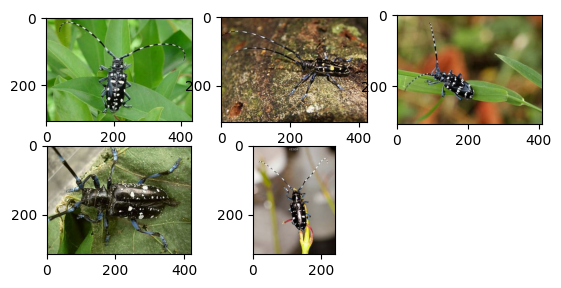

SLF
|▉▉▉▉▉▉▉▉⚠︎                               | (!) 1/5 [20%] in 0.1s (25.84/s)      
|▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉⚠︎                       | (!) 2/5 [40%] in 0.1s (71.36/s)      
|▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉⚠︎               | (!) 3/5 [60%] in 0.1s (148.59/s)     
|▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉⚠︎       | (!) 4/5 [80%] in 0.1s (186.73/s)     
|▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 5/5 [100%] in 0.1s (8106.09/s)       


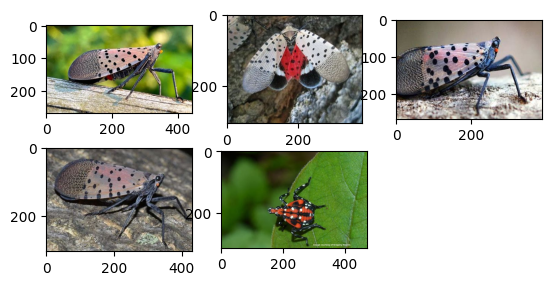

In [9]:
###########################################
#- Show pictures of the image dataset
###########################################

for idx, category in enumerate(categories_short_name):
  print(f"{start}{category.upper()}{end}")
  # define location of dataset
  #folder = './folderOnColab/bear/train/' + category
  folder = TRAIN_DATA_DIR + os.sep + category
  # plot first few images
  for i in range(range_max):
    idx=i+1
    with alive_bar(range_max,bar="blocks", spinner="fish2", force_tty=True) as bar:
      bar(idx)
      plt.subplot(plot_max + 1 + i)
      filename = folder + os.sep + f'00{idx}.jpg'
      image = imread(filename)
      plt.imshow(image)
  plt.show()



## Develop a Baseline CNN Model

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.

A good starting point is the general architectural principles of the VGG models.

In [10]:
# define cnn model with a single layer
def define_model_1Block():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)     #<- Hyperparameters
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
	return model

In [11]:
# define cnn model with two layers
def define_model_2Block():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
	return model

In [12]:
# define cnn model with 3 layers
# Adding dropout regularization is a computationally cheap way to regularize a deep neural network.
# Dropout works by probabilistically removing, or “dropping out,” inputs to a layer, which may be input variables
# in the data sample or activations from a previous layer. It has the effect of simulating a large number of networks
# with very different network structures and, in turn, making nodes in the network generally more robust to the inputs.
# https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

def define_model_3Block():
  model = Sequential()
  model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=1, activation="sigmoid"))
	# compile model
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
  return model

In [13]:
#define a new model using VGG16 with Transfer Learning
def define_model_TransferLearning():
  #transfer learning (VGG16)
  model = VGG16(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

  # mark loaded layers as un-trainable, keep the original weights
  for layer in model.layers:
      layer.trainable = False

  # add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)

  #this layer defines the classification, outputs much match total labels
  output = Dense(1, activation='sigmoid')(class1)

  # define new model
  model = Model(inputs=model.inputs, outputs=output)

  # optimization
  opt = SGD(learning_rate=0.001, momentum=0.9)

  # compile model
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

  return model


## Activation Functions

An activation function is applied on the last fully connected layer depending on the number of categories in the images. The sigmoid activation function is used in a binary problem, while the softmax activation function is applied in a multiclass task.    

## Compiling the model
To compile the neural network the gradient descent is applied. This is the optimization strategy that reduces the errors as the network is learning. There are various optimization strategies but sgd and adam are common approachs. In the compile stage, we also define the loss function and the metrics. We use sparse categorical cross-entropy because the labels are integers. The categorical cross-entropy is used when the labels are one-hot encoded.  

## Make the Models Active

In [14]:
# instantiate Models
model1 = define_model_1Block()
model2 = define_model_2Block()
model3 = define_model_3Block()
modelTransfer = define_model_TransferLearning()

## Model Input Source
### Use a generator to gather your data files

Prior to training the model, we need to normalize the pixel values of the data in the same range (e.g. 0 to 1). This is a common preprocessing step when dealing with images to ensure scale invariance, and faster convergence during the training.

In [15]:
#train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#data augmentation is a way to improve results, uncomment this line, replacing train_datagen and re-run your experiment
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=90,
                                   validation_split=0.2)

train_it = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training') # set as training data

test_it = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR, # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation') # set as validation data

#batch size is a hyper-parameter and has influence over training as well.  Larger batch sizes get done faster but take more memory, smaller batch sizes take longer but consume less memory.

Found 1558 images belonging to 2 classes.
Found 389 images belonging to 2 classes.


## Batch-Size

The choice of batch size can have a significant impact on the learning process. A smaller batch size can lead to faster convergence and can help the model escape from local minima. However, it also introduces more noise into the gradient estimate, which can lead to instability in the learning process.

A larger batch size, on the other hand, can provide a more stable learning process and a more accurate gradient estimate. However, it also requires more computational resources and may lead to slower convergence. Furthermore, it may increase the risk of the model getting stuck in local minima.

## Create a Custom Class for Visualization during Model Training

In [16]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []


    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

## What is Loss and Accruacy?

The lower the loss, the better a model (unless the model has over-fitted to the training data). The loss is calculated on training and validation and its interperation is how well the model is doing for these two sets. Unlike accuracy, loss is not a percentage. It is a summation of the errors made for each example in training or validation sets.

In the case of neural networks, the loss is usually negative log-likelihood and residual sum of squares for classification and regression respectively. Then naturally, the main objective in a learning model is to reduce (minimize) the loss function's value with respect to the model's parameters by changing the weight vector values through different optimization methods, such as backpropagation in neural networks.

Loss value implies how well or poorly a certain model behaves after each iteration of optimization. Ideally, one would expect the reduction of loss after each, or several, iteration(s).

The accuracy of a model is usually determined after the model parameters are learned and fixed and no learning is taking place. Then the test samples are fed to the model and the number of mistakes (zero-one loss) the model makes are recorded, after comparison to the true targets. Then the percentage of misclassification is calculated.

For example, if the number of test samples is 1000 and model classifies 952 of those correctly, then the model's accuracy is 95.2%.

### Define an Early Stopper to prevent Overfitting

In [17]:
#specify a call back

#simple callback to show results real-time
#callbacks_list = [PlotLearning()]

#another way to increase performance is to stop early, try commenting out the previous callback list
#and uncommenting this one.  See the EPOCHS go from full execution to a shortened cycle.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

## Train 1 Block Model

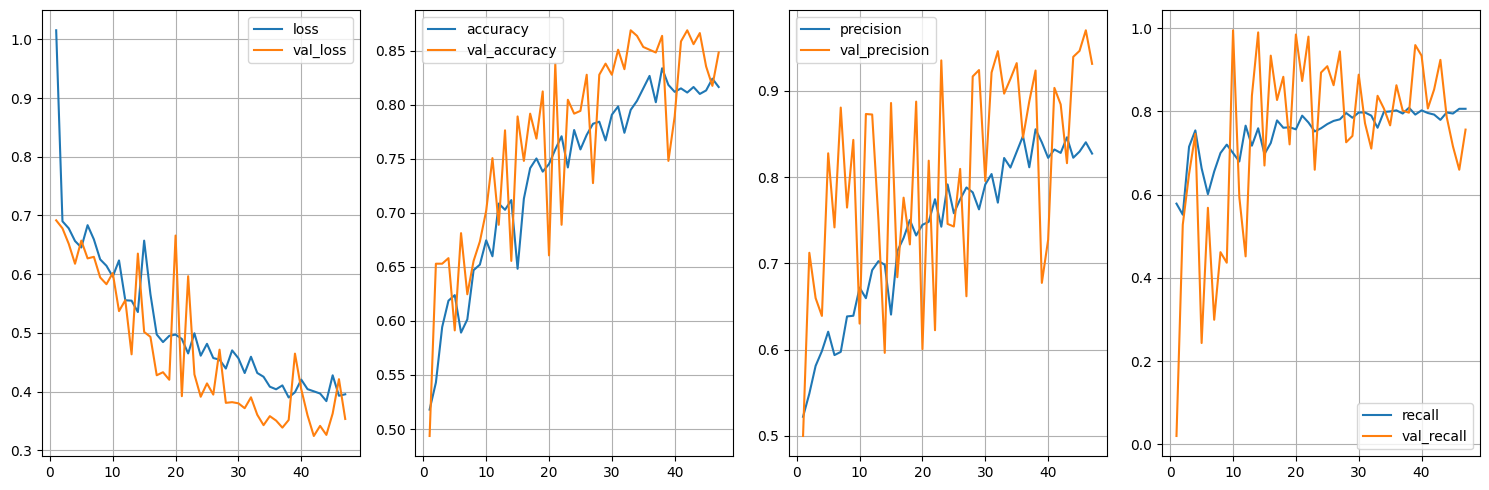


Epoch 47: val_accuracy did not improve from 0.86889
25/25 [==============================] - 56s 2s/step - loss: 0.3956 - accuracy: 0.8164 - precision: 0.8273 - recall: 0.8063 - val_loss: 0.3536 - val_accuracy: 0.8483 - val_precision: 0.9312 - val_recall: 0.7563
Epoch 47: early stopping


In [18]:
# fit model
mc = ModelCheckpoint('best_model1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks_list = [PlotLearning(), es, mc]

history1 = model1.fit_generator(train_it,
                              steps_per_epoch=len(train_it),
                              validation_data=test_it,
                              validation_steps=len(test_it),
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callbacks_list,
)

## Train Model 2 Block (2 layers)

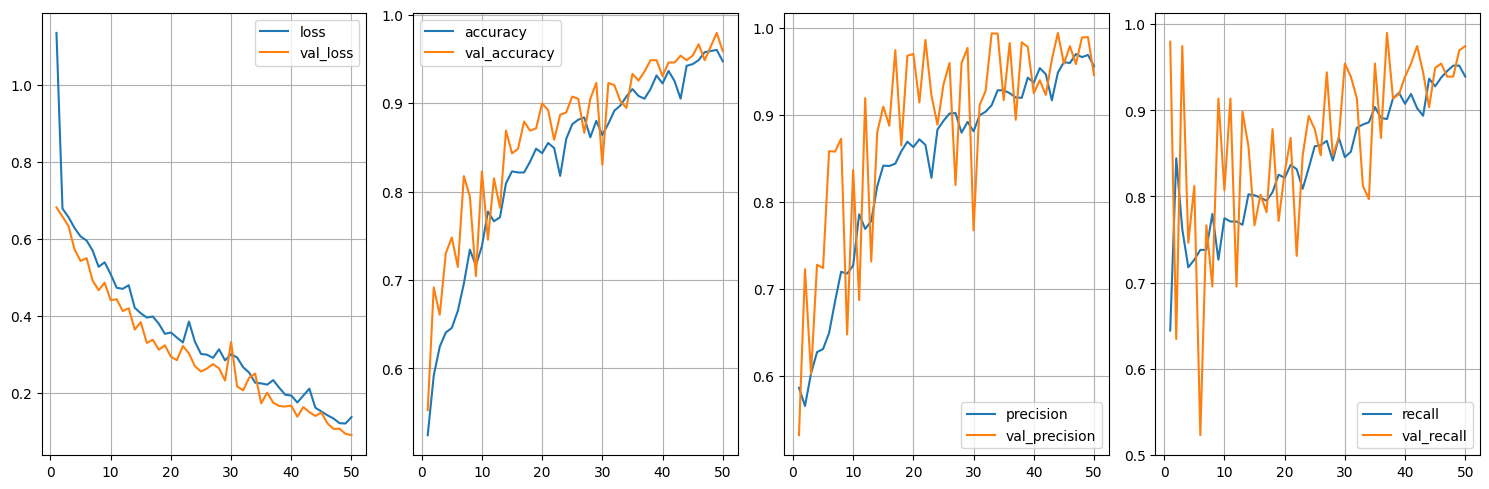


Epoch 50: val_accuracy did not improve from 0.97943
25/25 [==============================] - 83s 3s/step - loss: 0.1370 - accuracy: 0.9474 - precision: 0.9562 - recall: 0.9392 - val_loss: 0.0900 - val_accuracy: 0.9589 - val_precision: 0.9458 - val_recall: 0.9746


In [19]:
# fit model
mc = ModelCheckpoint('best_model2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks_list = [PlotLearning(), es, mc]

history2 = model2.fit_generator(train_it,
                              steps_per_epoch=len(train_it),
                              validation_data=test_it,
                              validation_steps=len(test_it),
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callbacks_list,
)

## Train Model 3 Block (3 layers)

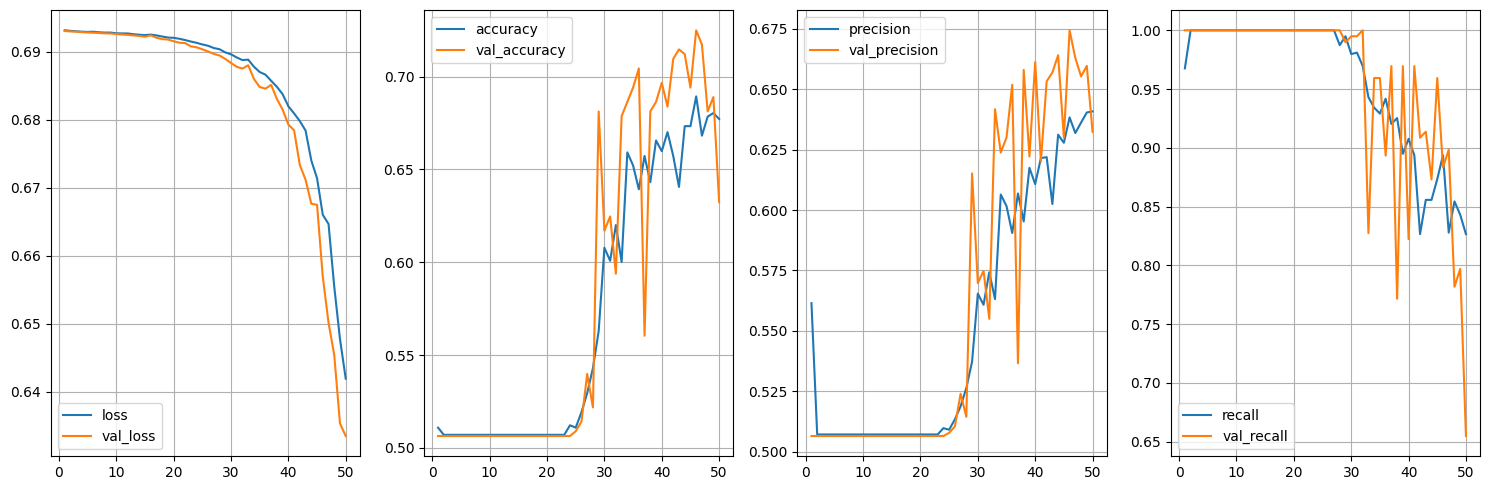


Epoch 50: val_accuracy did not improve from 0.72494
25/25 [==============================] - 1504s 60s/step - loss: 0.6419 - accuracy: 0.6772 - precision: 0.6408 - recall: 0.8266 - val_loss: 0.6335 - val_accuracy: 0.6324 - val_precision: 0.6324 - val_recall: 0.6548


In [20]:
# fit model
mc = ModelCheckpoint('best_model3.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks_list = [PlotLearning(), es, mc]

history3 = model3.fit_generator(train_it,
                              steps_per_epoch=len(train_it),
                              validation_data=test_it,
                              validation_steps=len(test_it),
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callbacks_list,
)

## Transfer Learning Model (VGG 16)

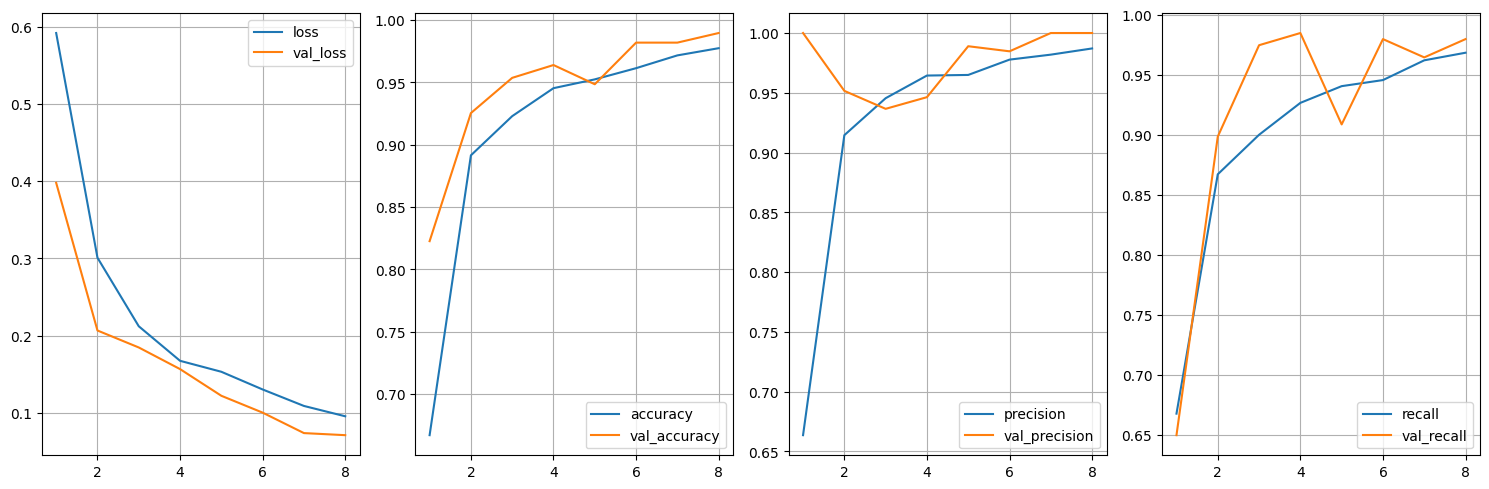


Epoch 8: val_accuracy improved from 0.98201 to 0.98972, saving model to best_modelVGG16.h5
25/25 [==============================] - 487s 20s/step - loss: 0.0958 - accuracy: 0.9775 - precision: 0.9871 - recall: 0.9684 - val_loss: 0.0714 - val_accuracy: 0.9897 - val_precision: 1.0000 - val_recall: 0.9797
Epoch 9/50
25/25 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.9788 - precision: 0.9922 - recall: 0.9658 

KeyboardInterrupt: 

In [21]:
# fit model
#another way to increase performance is to stop early, try commenting out the previous callback list
#and uncommenting this one.  See the EPOCHS go from full execution to a shortened cycle.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_modelVGG16.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks_list = [PlotLearning(), es, mc]

historyTransfer = modelTransfer.fit_generator(train_it,
                              steps_per_epoch=len(train_it),
                              validation_data=test_it,
                              validation_steps=len(test_it),
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callbacks_list,
)

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics_seaborn(history, title):
  # Create pandas DataFrame
  df_history = pd.DataFrame(history.history)
  #print(df_history)

  #turn values into real percents
  df_history['Training_Accuracy'] = df_history["accuracy"] * 100.0
  df_history['Validation_Accuracy'] = df_history["val_accuracy"] * 100.0

  #color palette
  palette = ['r','b','g']

  # Plot using Seaborn
  sns.set_style("darkgrid", {"axes.facecolor": ".9"})
  sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
  fig = plt.figure(figsize=[7,5])
  ax = plt.subplot(111)
  my_plot = sns.lineplot(data=df_history[["Training_Accuracy","Validation_Accuracy"]],
                         markers=True, dashes=False,palette=palette)

  my_plot.set_xlabel('Epochs')
  my_plot.set_ylim(0,100)
  my_plot.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
  my_plot.set_ylabel('Accuracy')

  plt.title('Training and Validation Loss \n' + title)
  ttl = ax.title
  ttl.set_weight('bold')


  plt.show()

In [ ]:
def show_performance_curve(training_result, metric, metric_label):

	train_perf = training_result.history[str(metric)]
	validation_perf = training_result.history['val_'+str(metric)]
	intersection_idx = np.argwhere(np.isclose(train_perf, validation_perf, atol=1e-2)).flatten()[0]
	intersection_value = train_perf[intersection_idx]

	fig = plt.figure(figsize=[7,5])
	plt.plot(train_perf, label=metric_label)
	plt.plot(validation_perf, label = 'val_'+str(metric))
	plt.axvline(x=intersection_idx, color='r', linestyle='--', label='Intersection')

	plt.annotate(f'Optimal Value: {intersection_value:.4f}',
         	xy=(intersection_idx, intersection_value),
         	xycoords='data',
         	fontsize=10,
         	color='green')

	plt.xlabel('Epoch')
	plt.ylabel(metric_label)
	plt.legend(loc='lower right')
	plt.title(metric)
	plt.show()

## Model Evaluation

In [ ]:
# evaluate model
print(f'  {start}1 Layer Model{end}')
loss, accuracy, precision, recall = model1.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print(f'  {start}Loss{end} > {loss: .2f}')
print(f'{start}Accuracy{end}> {accuracy: .2%}')
print('\n')
summarize_diagnostics_seaborn(history1, "One Layer")
show_performance_curve(history1, 'accuracy', 'accuracy')
show_performance_curve(history1, 'precision', 'precision')


In [ ]:
print("\n")
print(f'  {start}2 Layer Model{end}')
loss, accuracy, precision, recall = model2.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print(f'  {start}Loss{end} > {loss: .2f}')
print(f'{start}Accuracy{end}> {accuracy: .2%}')
print("\n\n")
summarize_diagnostics_seaborn(history2, "Two Layers")
show_performance_curve(history2, 'accuracy', 'accuracy')
show_performance_curve(history2, 'precision', 'precision')

In [1]:
print("\n")
print(f'  {start}3 Layer Model{end}')
loss, accuracy, precision, recall = model3.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print(f'  {start}Loss{end} > {loss: .2f}')
print(f'{start}Accuracy{end}> {accuracy: .2%}')
print("\n\n")
summarize_diagnostics_seaborn(history3, "Three Layers")
show_performance_curve(history3, 'accuracy', 'accuracy')
show_performance_curve(history3, 'precision', 'precision')

NameError: name 'start' is not defined

In [ ]:
print("\n")
print(f'  {start}VGG16 Model{end}')
loss, accuracy, precision, recall = modelTransfer.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print(f'  {start}Loss{end} > {loss: .2f}')
print(f'{start}Accuracy{end}> {accuracy: .2%}')

print("\n\n")
summarize_diagnostics_seaborn(historyTransfer, "Transfer Learning")
show_performance_curve(historyTransfer, 'accuracy', 'accuracy')
show_performance_curve(historyTransfer, 'precision', 'precision')

## Inference for Each Model Trained

In [ ]:
IS_TRUTH=0.51

# load and prepare the image
def load_image(img):
 #resize the image
 newsize = (IMG_HEIGHT, IMG_WIDTH)
 img1 = img.resize(newsize)
 # convert to array
 img2 = img_to_array(img1)
 # reshape into a single sample with 3 channels
 img = img2.reshape(1, IMG_HEIGHT, IMG_WIDTH, 3)
 # ensure datatype
 img = img.astype('float32')
 # scale image
 img = img / 255.0


 return img

# load an image and predict the class
def run_example(inc_url, inc_model):
 # load the image
 img = load_image(inc_url)
 # predict the class
 result = inc_model.predict(img)
 return result

# entry point, run the example
#sad bear
#url = 'https://images.fineartamerica.com/images/artworkimages/mediumlarge/3/1-sad-eyes-bear-jay-sheinfield.jpg'
#sad bear (from dataset)
#url = 'https://laughingsquid.com/wp-content/uploads/2016/06/gxrb_bn-iwbd1o7gyrsxyojbeilmz45j7zmzcaxf77y.jpg'
#img = Image.open(requests.get(url, stream=True).raw)

filename="./folderInColab/ENTOMOLOGY/SPOTTED_LANTERN_FLY/011.png"
img = load_img(filename, target_size=(IMG_HEIGHT, IMG_WIDTH))

best_model1 = load_model('./best_model1.h5')
best_model2 = load_model('./best_model2.h5')
best_model3 = load_model('./best_model3.h5')
best_modelVGG16 = load_model('./best_modelVGG16.h5')

results1 = run_example(img, best_model1)
results2 = run_example(img, best_model2)
results3 = run_example(img, best_model3)
resultsVGG16 = run_example(img, best_modelVGG16)



In [ ]:
predicted_class_index = np.argmax(results1)
predicted_class = class_names[predicted_class_index]
print(f'  {start}1 Layer Model{end}')
print(f'{start}predicted_class{end}> {results1}')

print("\n")
predicted_class_index = np.argmax(results2)
predicted_class = class_names[predicted_class_index]
print(f'  {start}2 Layer Model{end}')
print(f'{start}predicted_class{end}> {results2}')

print("\n")
predicted_class_index = np.argmax(results3)
predicted_class = class_names[predicted_class_index]
print(f'  {start}3 Layer Model{end}')
print(f'{start}predicted_class{end}> {results3}')

print("\n")
predicted_class_index = np.argmax(results1)
predicted_class = class_names[predicted_class_index]
print(f'  {start}VGG16 Transfer Learning Model{end}')
print(f'{start}predicted_class{end}> {resultsVGG16}')



## Show the Model Layers

In [ ]:
try:
  #best_model1, best_model2, best_model3, best_modelTransfer
  target_model='best_model3'

except Exception as e:
  print(f'ERROR: Problem detected while loading model: {str(e)}')

try:
  tf.keras.utils.plot_model(
      load_model(target_model+'.h5'),
      to_file='./'+target_model+'.png',
      show_shapes=True,
      show_layer_names=True,
      rankdir="TB",
      expand_nested=True,
      dpi=96,
  )
except Exception as e:
  print(f'ERROR: Problem detected while plotting model: {str(e)}')

try:
  img=Image.open('./'+target_model+'.png')
  img.show()
except Exception as e:
  print(f'ERROR: Unable to display the image: {str(e)}')
